In [57]:
from torch_compose.module import DirectedModule, ModuleGraph
import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


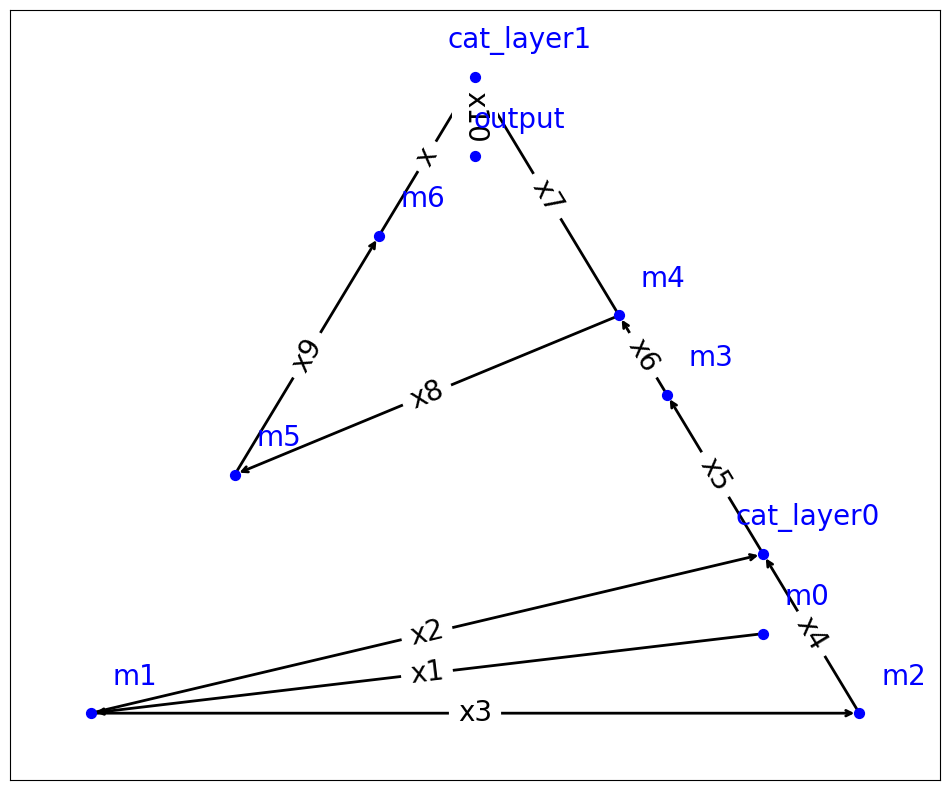

In [77]:
class DictOutput(DirectedModule):
    def forward(self, x):
        xx = x + 1
        return {'x': xx}
    
    
class TupleOutput(DirectedModule):
    
    def forward(self, x):
        x_squared = x**2
        return x, x_squared
    
class TensorOutput(DirectedModule):
    
    def forward(self, x):
        return -x
    
class CatModule(DirectedModule):
    
    def forward(self, *args, **kwargs):
        inputs = list(args) + list(kwargs.values())
        return torch.cat(inputs, dim=0)
    
class DictMultiOutput(DirectedModule):
    def forward(self, x):
        x
        return {'x': x, 'y': x+1}
    
g = ModuleGraph(
    modules={
        'm0': DictOutput(input_keys=['x0'], output_keys = {'x': 'x1'}),
        'm1': TupleOutput(input_keys=['x1'], output_keys = ['x2', 'x3']),
        'm2': TensorOutput(input_keys=['x3'], output_keys = ['x4']),
        'cat_layer0': CatModule(input_keys=['x2', 'x4'], output_keys = ['x5']),
        'm3': TensorOutput(input_keys='x5', output_keys = 'x6'),
        'm4': DictMultiOutput(input_keys='x6', output_keys = {'x': 'x7', 'y': 'x8'}),
        'm5': DictMultiOutput(input_keys=['x8'], output_keys = {'x': 'x9',}),
        'm6': DictMultiOutput(input_keys={'x9': 'x'}, output_keys = ['x']),
        'cat_layer1': CatModule(input_keys=['x7', 'x', 'x8'], output_keys = ['x']),
        })
new_batch = g.forward(batch = {'x0': torch.tensor(1.).unsqueeze(0)})
g.show_graph()

In [81]:
import torch
from torch.nn import functional as F
import torch.nn as nn

class Backbone(DirectedModule):
    def __init__(self, backbone_model, input_keys, output_keys):
        super().__init__(input_keys=input_keys, output_keys=output_keys)
        self.backbone_model = backbone_model

class ProjectionHead(DirectedModule):
    def __init__(self, output_dim, input_keys, output_keys):
        super().__init__(input_keys=input_keys, output_keys=output_keys)
        self.projection_head = nn.Sequential(
            nn.Linear(1000, 2048),
            nn.ReLU(),
            nn.Linear(2048, output_dim),
        )

class BarlowTwinsLoss(DirectedModule):
    def __init__(self, batch_size, lambda_param, input_keys, output_keys):
        super().__init__(input_keys=input_keys, output_keys=output_keys)
        self.batch_size = batch_size
        self.lambda_param = lambda_param

class RegressionHead(DirectedModule):
    def __init__(self, input_keys, output_keys):
        super().__init__(input_keys=input_keys, output_keys=output_keys)
        self.fc = nn.Linear(128, 1)

class ClassificationHead(DirectedModule):
    def __init__(self, num_classes, input_keys, output_keys):
        super().__init__(input_keys=input_keys, output_keys=output_keys)
        self.fc = nn.Linear(128, num_classes)

class CombinedLoss(DirectedModule):
    def __init__(self, weights, input_keys, output_keys):
        super().__init__(input_keys=input_keys, output_keys=output_keys)
        self.weights = weights


graph = ModuleGraph(
    modules={
        'backbone': Backbone(backbone_model=None, input_keys=['input1', 'input2'], output_keys=['backbone_output1', 'backbone_output2']),
        'projection': ProjectionHead(output_dim=128, input_keys=['backbone_output1', 'backbone_output2'], output_keys=['projection_output1', 'projection_output2']),
        'barlow_loss': BarlowTwinsLoss(batch_size=64, lambda_param=0.005, input_keys=['projection_output1', 'projection_output2'], output_keys='barlow_loss'),
        'regression_head': RegressionHead(input_keys='projection_output1', output_keys='regression_output'),
        'classification_head': ClassificationHead(num_classes=10, input_keys='projection_output2', output_keys='classification_output'),
        'combined_loss': CombinedLoss(weights=[0.5, 0.25, 0.25], input_keys=['barlow_loss', 'regression_output', 'classification_output'], output_keys='loss'),
    }
)


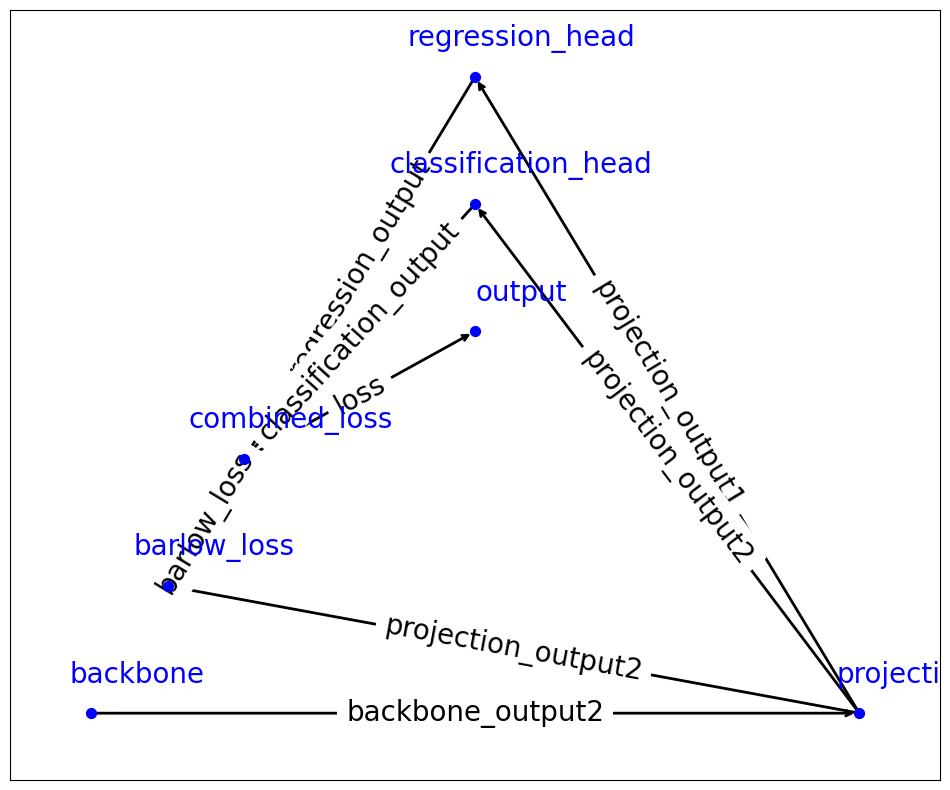

In [82]:
graph.show_graph()